## Modelling 

After cleaning and performing Exploratory Data Analysis (EDA), this notebook hopes to develop a model that is accurate and high performing. Through EDA, we have identified few variables that we hope to perform:

* Feature Engineering on selected features identified in EDA
* Preprocessing of features before modelling
* Performing Model Evaluations 

# Import Libraries

In [1]:
# Import necessary libs
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Loading .csv file of imputed values from train.csv

In [2]:
# Load data
price = pd.read_csv("../data/train_imputed.csv")

# Feature Engineering 
Based on EDA, strong correlations and domain research have been identified in features in train dataset such as:

* Mature Estates
* Town Region
* Proximity of Primary and Secondary Schools
* Number of Apartments Per Storey
* Average distance of key amenities
* Binarization of key amenities
* HDB Flat Models

> From existing variables, we create new features that have strong correlations with HDB resale prices that can bolster the predictive power of our model. 

In [3]:
# Feature engineering for mature estate
mature_estates = ["ANG MO KIO", "BEDOK", "BISHAN", "BUKIT MERAH", "BUKIT TIMAH", "CENTRAL AREA", "CLEMENTI", "GEYLANG", "KALLANG/WHAMPOA", "MARINE PARADE"]
price['mature_estate'] = price['town'].apply(lambda x: 1 if x in mature_estates else 0)

In [4]:
# Feature engineering for north, south, east, west and central
central = ['BISHAN', 'BUKIT MERAH', 'GEYLANG', 'KALLANG/WHAMPOA', 'MARINE PARADE', 'QUEENSTOWN', 'SOUTHERN ISLANDS', 'TOA PAYOH', 'CENTRAL AREA']
price['central'] = price['town'].apply(lambda x: 1 if x in central else 0)

east = ['BEDOK', 'CHANGI', 'CHANGI BAY', 'PAYA LEBAR', 'PASIR RIS', 'TAMPINES']
price['east'] = price['town'].apply(lambda x: 1 if x in east else 0)

north = ['CENTRAL WATER CATCHMENT', 'LIM CHU KANG', 'MANDAI', 'SEMBAWANG', 'SIMPANG', 'SUNGEI KADUT', 'WOODLANDS', 'YISHUN']
price['north'] = price['town'].apply(lambda x: 1 if x in north else 0)

north_east = ['ANG MO KIO', 'HOUGANG', 'NORTH-EASTERN ISLANDS', 'PUNGGOL', 'SELETAR', 'SENGKANG', 'SERANGOON']
price['north_east'] = price['town'].apply(lambda x: 1 if x in north_east else 0)

west = ['BUKIT BATOK', 'BUKIT PANJANG', 'BOON LAY', 'PIONEER', 'CHOA CHU KANG', 'CLEMENTI', 'JURONG EAST', 'JURONG WEST', 'TENGAH', 'TUAS', 'WESTERN ISLANDS', 'WESTERN WATER', 'CATCHMENT', 'BENOI', 'GHIM MOH', 'GUL', 'PANDAN GARDENS', 'JURONG ISLAND', 'KENT RIDGE', 'NANYANG', 'PIONEER', 'PASIR LABA', 'TEBAN GARDENS', 'TOH TUCK', 'TUAS SOUTH', 'WEST COAST']
price['west'] = price['town'].apply(lambda x: 1 if x in west else 0)

In [5]:
# Feature engineering for Total schools within 1km
price['total_schools_within_1km'] = (price['sec_sch_nearest_dist'] <= 1000).astype(int) + (price['pri_sch_nearest_distance'] <= 1000).astype(int)

In [7]:
# Feature engineering for units per floor
# Create the 'unit per floor' feature
price['unit_per_floor'] = price['total_dwelling_units'] / price['max_floor_lvl']

In [9]:
# Calculate the average distance to MRT, Mall, and Hawker
price['avg_distance_to_key_locations'] = (price['mrt_nearest_distance'] + price['Mall_Nearest_Distance'] + price['Hawker_Nearest_Distance']) / 3


In [12]:
# Convert 'N' to 0 and 'Y' to 1 for specific columns
price['multistorey_carpark'] = price['multistorey_carpark'].map({'N': 0, 'Y': 1})
price['precinct_pavilion'] = price['precinct_pavilion'].map({'N': 0, 'Y': 1})
price['commercial'] = price['commercial'].map({'N': 0, 'Y': 1})

In [13]:
#Feature Engineering: Masionette 
maisonette = ["Improved-Maisonette", "Maisonette", "Model A-Maisonette", "Premium Maisonette"]

#Feature Engineering: Unique HDB models
unique_models = ["DBSS", "Type S1", "Type S2", "Apartment", "Adjoined flat", "Terrace"] + maisonette
price["unique_model"] = [1 if model in unique_models else 0 for model in price["flat_model"]]

# Standardisation of Modelling Features

As linear models allow better performance by reducing the range, preprocessing steps are taken. Categorical variables are dummified.

In [14]:
# list of selected numerical features
selected_numerical_features = [
    'floor_area_sqm', 'mrt_nearest_distance',
    'Hawker_Within_1km', 'Mall_Nearest_Distance', 'Mall_Within_1km',
    'max_floor_lvl', 'mature_estate', 'unit_per_floor', 'multistorey_carpark', 'precinct_pavilion',
    'commercial', 'total_dwelling_units', 'hdb_age',
    'Tranc_Year', 'Tranc_Month', 'mid_storey', 'vacancy', 'avg_distance_to_key_locations', 
    'unique_model', 'total_schools_within_1km','hawker_market_stalls',
    'central', 'east', 'north', 'north_east', 'west'
]

In [15]:
# List of selected categorical features
selected_categorical_features = ['town','storey_range']

In [16]:
# Numerical pipeline: scaling and polynomial features
num_pipeline = Pipeline([
  ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2))
 ])

In [17]:
# ColumnTransformer
# Different data attributes requires different preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, selected_numerical_features),('cat', OneHotEncoder(drop='first'), selected_categorical_features)
])

In [18]:
# Extracting the relevant features
selected_data_imputed = price[selected_numerical_features + selected_categorical_features]

# Prepare Training and Test datasets

A train-test split of 80-20 has been chosen

In [19]:
# Train-test split
y = (price['resale_price'])
X_train, X_test, y_train, y_test = train_test_split(selected_data_imputed, y, test_size=0.2, random_state=2)
X_train.head()

,floor_area_sqm,mrt_nearest_distance,Hawker_Within_1km,Mall_Nearest_Distance,Mall_Within_1km,max_floor_lvl,mature_estate,unit_per_floor,multistorey_carpark,precinct_pavilion,...,unique_model,total_schools_within_1km,hawker_market_stalls,central,east,north,north_east,west,town,storey_range
62829,127.0,411.828160,1.0,2031.273954,1.0,12,1,7.083333,0,0,...,0,2,75,0,1,0,0,0,BEDOK,07 TO 09
137824,85.0,1450.176785,1.0,482.702330,2.0,17,0,8.117647,0,0,...,0,2,0,0,0,0,1,0,SENGKANG,07 TO 09
128025,103.0,492.165442,1.0,347.640578,1.0,8,0,7.875000,0,0,...,0,2,94,0,0,0,0,1,JURONG WEST,07 TO 09
89497,110.0,1305.193879,1.0,399.429047,2.0,17,0,6.764706,0,0,...,0,2,0,0,0,0,1,0,SENGKANG,13 TO 15
73541,67.0,682.481418,2.0,792.139275,2.0,16,0,11.250000,0,0,...,0,2,0,0,0,0,1,0,PUNGGOL,01 TO 03


In [20]:
# Initialize models
lasso = Lasso()
linear = LinearRegression()
ridge = Ridge()

In [21]:
# Create a list to store the models
models = [lasso, linear, ridge]
model_names = ['Lasso', 'Linear Regression', 'Ridge']

In [22]:
# Loop through each model to train, predict, and evaluate
for model, name in zip(models, model_names):
    print(f"---- {name} ----")
    
    # Create pipeline
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', model)])
    
    # Train the model on the training data
    pipeline.fit(X_train, y_train)
    
    # Make predictions on the test and training sets
    y_pred_test = pipeline.predict(X_test)
    y_pred_train = pipeline.predict(X_train)
    
    # Calculate RMSE and R^2 for the test set
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    r2_test = r2_score(y_test, y_pred_test)
    
    # Calculate RMSE and R^2 for the training set
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    r2_train = r2_score(y_train, y_pred_train)
    
    # Print the metrics
    print(f"Test RMSE for {name}: {rmse_test}")
    print(f"Test R^2 for {name}: {r2_test}")
    print(f"Train RMSE for {name}: {rmse_train}")
    print(f"Train R^2 for {name}: {r2_train}")
    print("------------")

---- Lasso ----
Test RMSE for Lasso: 37353.726747633475
Test R^2 for Lasso: 0.9320608274997072
Train RMSE for Lasso: 37732.41076770855
Train R^2 for Lasso: 0.9306735358330613
------------
---- Linear Regression ----
Test RMSE for Linear Regression: 37341.85996050149
Test R^2 for Linear Regression: 0.932103987403978
Train RMSE for Linear Regression: 37715.232613666914
Train R^2 for Linear Regression: 0.9307366449517287
------------
---- Ridge ----
Test RMSE for Ridge: 37349.21362292356
Test R^2 for Ridge: 0.9320772435021729
Train RMSE for Ridge: 37716.828544211596
Train R^2 for Ridge: 0.9307307830314889
------------


### Create Residual Plot

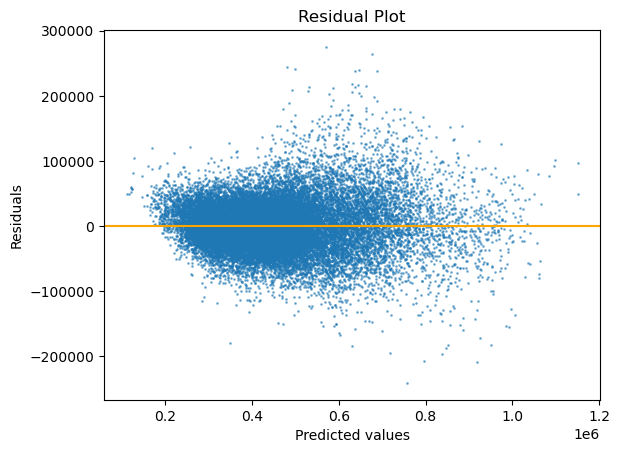

count     30127.000000
mean         -5.639796
std       37349.833075
min     -241220.755691
25%      -22448.310678
50%       -1144.662321
75%       20810.331958
max      275169.812177
Name: resale_price, dtype: float64

In [23]:
# Scatter plot
models = [linear]
model_names = ['Linear Regression']

y_pred_test = pipeline.predict(X_test)

# Create residuals (aka errors): (y - y_hat)
resids = y_test - y_pred_test

plt.scatter(y_pred_test, resids, s=1, alpha = 0.5)
plt.axhline(0, color="orange");


# Title and labels
plt.title('Residual Plot')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')

# Show the plot
plt.show()
resids.describe()